In [231]:
from typing import Iterable, NamedTuple
from poclaps.train.ckpt_cb import load_ckpt
from poclaps.train.ppo import make_train as make_ppo_train
from poclaps.train.ppo import FlattenObservationWrapper, LogWrapper
from poclaps import environments

from pathlib import Path
import yaml

from poclaps.train.training_cb import TrainerCallback


# run_dir = Path('outputs/2024-06-11/19-46-55')
run_dir = Path('outputs/2024-06-14/15-39-35/')
run_dir2 = Path('outputs/2024-06-15/00-58-28/')


def load_config(run_dir):
    with open(f'{run_dir}/.hydra/config.yaml') as f:
        config = yaml.safe_load(f)
        config['output_dir'] = run_dir
    return config

config = load_config(run_dir)
config2 = load_config(run_dir2)

init_state, train_fn = make_ppo_train(config)

print(config)

def load_pretrained_policy(run_dir, config, ckpt_step=195):
    init_state, _ = make_ppo_train(config)
    ckpt = load_ckpt(run_dir / 'checkpoints', ckpt_step, init_state)
    train_state, *_ = ckpt

    def pretrained_policy(obs):
        return train_state.apply_fn(train_state.params, obs)

    return pretrained_policy

pretrained_policy = load_pretrained_policy(run_dir, config)
pretrained_policy2 = load_pretrained_policy(run_dir2, config2)
print('Loaded policy checkpoint.')

env, env_params = environments.make(config["env_name"],
                                    **config.get('env_kwargs', {}))
env = FlattenObservationWrapper(env)
env = LogWrapper(env)


import jax
from flax import struct
from chex import Array
import jax.numpy as jnp

{'algorithm': 'PPO', 'learning_rate': 0.00025, 'num_envs': 4, 'num_steps': 128, 'total_timesteps': 100000.0, 'update_epochs': 4, 'num_minibatches': 4, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_eps': 0.2, 'ent_coef': 0.01, 'vf_coef': 0.5, 'max_grad_norm': 0.5, 'activation': 'tanh', 'anneal_lr': True, 'seed': 0, 'env_name': 'SimpleGridWorld-v0', 'env_kwargs': {'grid_size': 5, 'max_steps_in_episode': 20}, 'wandb_entity': 'drcope', 'wandb_project': 'ppo-gridworld-example', 'wandb_mode': 'online', 'output_dir': PosixPath('outputs/2024-06-14/15-39-35'), 'num_updates': 195.0, 'minibatch_size': 128}
Loaded policy checkpoint.


In [335]:
class Transition(NamedTuple):
    env_state: struct.PyTreeNode
    done: Array
    action: Array
    message: Array
    reward: Array
    log_prob: Array
    obs: Array
    info: dict
    episode_id: int


class SimpleGridWorldCommPolicy:
    """
    """

    def __init__(self, seed: int, env_params: SimpleGridWorldEnvParams):
        self.seed = seed
        self.env_params = env_params
        self.n_msgs = env_params.grid_size * env_params.grid_size
        grid_indices = list(range(self.n_msgs))
        np.random.seed(seed)
        np.random.shuffle(grid_indices)
        self.msg_map = dict(enumerate(grid_indices))
        self.mapping = jnp.array(list(self.msg_map.values()))

    def get_msg(self, goal_pos: jnp.array) -> int:
        pos_idx = goal_pos[0] * self.env_params.grid_size + goal_pos[1]
        return self.mapping[pos_idx]

comm_policy = SimpleGridWorldCommPolicy(0, env_params)


def rollout_with_msgs(env, policy, comm_policy, steps, n_envs=4, rng=None, rollout_state=None):

    @jax.jit
    def _env_step(rollout_state, _):
        env_state, last_obs, rng, ep_ids = rollout_state

        # SELECT ACTION
        rng, _rng = jax.random.split(rng)
        pi, _ = policy(last_obs)
        action = pi.sample(seed=_rng)
        log_prob = pi.log_prob(action)

        # STEP ENV
        rng, _rng = jax.random.split(rng)
        rng_step = jax.random.split(_rng, n_envs)
        obsv, env_state, reward, done, info = jax.vmap(
            env.step, in_axes=(0, 0, 0, None)
        )(rng_step, env_state, action, env_params)
        ep_ids = jnp.where(done, ep_ids + n_envs, ep_ids)

        msg = jax.lax.map(
            lambda g: comm_policy.get_msg(g),
            env_state.env_state.goal_pos
        )

        transition = Transition(
            env_state, done, action, msg, reward, log_prob, last_obs, info, ep_ids
        )
        rollout_state = (env_state, obsv, rng, ep_ids)
        return rollout_state, transition

    if rollout_state is None:
        if rng is None:
            rng = jax.random.PRNGKey(0)
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, n_envs)
        obsv, env_state = jax.vmap(env.reset,
                                   in_axes=(0, None))(reset_rng, env_params)
        ep_ids = jnp.arange(n_envs)
        rollout_state = (env_state, obsv, rng, ep_ids)

    rollout_state, traj_batch = jax.lax.scan(
        _env_step, rollout_state, None, steps
    )

    metrics = {}

    metrics['mean_reward'] = (
        (traj_batch.info["returned_episode_returns"] * traj_batch.info["returned_episode"]).sum()
        / traj_batch.info["returned_episode"].sum()
    )

    metrics['mean_episode_len'] = (
        (traj_batch.info["returned_episode_lengths"] * traj_batch.info["returned_episode"]).sum()
        / traj_batch.info["returned_episode"].sum()
    )

    metrics['n_episodes'] = traj_batch.info["returned_episode"].sum()

    return rollout_state, traj_batch, metrics


rollout_state, traj_batch, metrics = rollout_with_msgs(env, pretrained_policy, comm_policy, 500)


import numpy as np
from poclaps.simple_gridworld_game import (
    EnvState as SimpleGridWorldEnvState,
    EnvParams as SimpleGridWorldEnvParams,
)

# goal_pos_batch = traj_batch.env_state.env_state.goal_pos
# goal_idxs = goal_pos_batch[:, :, 0] * env_params.grid_size + goal_pos_batch[:, :, 1]

# msgs_batch = mapping[goal_idxs]

import flax.linen as nn
import jax
import functools

In [336]:
class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(*rnn_state.shape),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


In [337]:
class ScannedBiRNN(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, carry, inputs):
        forward_carry, backward_carry = carry
        forward_carry, forward_embs = ScannedRNN(self.hidden_size)(
            forward_carry, inputs
        )
        feats, resets = inputs
        backward_inputs = (feats[::-1], resets[::-1])
        backward_carry, backward_embs = ScannedRNN(self.hidden_size)(
            backward_carry, backward_inputs
        )
        carry = (forward_carry, backward_carry)
        embs = jnp.concatenate([forward_embs, backward_embs], axis=-1)
        return carry, embs

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        return (
            ScannedRNN.initialize_carry(n_envs, hidden_size),
            ScannedRNN.initialize_carry(n_envs, hidden_size)
        )

In [189]:
class ObsModel(nn.Module):
    obs_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, actions, messages, dones):
        feats = jnp.concatenate([actions, messages], axis=-1)
        carry = ScannedBiRNN.initialize_carry(config['num_envs'], self.hidden_size)
        bi_lstm = ScannedBiRNN(self.hidden_size)
        _, embs = bi_lstm(carry, (feats, dones))
        obs_preds = nn.Dense(self.obs_size)(embs)
        obs_preds = nn.sigmoid(obs_preds)
        return obs_preds

In [197]:
obs_space = env.observation_space(env_params)
obs_size = obs_space.shape[0]

In [210]:
N_ACTIONS = 5
actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
msgs_1h = jax.nn.one_hot(msgs_batch, comm_policy.n_msgs)

hidden_size = 128

obs_model = ObsModel(obs_size, hidden_size)
variables = obs_model.init(jax.random.PRNGKey(0), actions_1h, msgs_1h, traj_batch.done)

In [211]:
obs_preds = obs_model.apply(variables, actions_1h, msgs_1h, traj_batch.done)
obs_preds.shape

(500, 4, 20)

In [219]:
from poclaps.train.losses import categorical_cross_entropy

pred_action_dist, _ = pretrained_policy(traj_batch.obs)
loss = categorical_cross_entropy(pred_action_dist.logits, actions_1h)

In [377]:
from poclaps.train.losses import categorical_cross_entropy

import optax
from flax.training.train_state import TrainState


class TrainerState(NamedTuple):
    train_state: TrainState
    rng: jnp.ndarray


class ObsModelTrainer:

    def __init__(self,
                 obs_model,
                 pretrained_policy,
                 sample_batch: callable):
        self.obs_model = obs_model
        self.pretrained_policy = pretrained_policy
        self.sample_batch = sample_batch

    def compute_loss(self, variables, inputs):
        actions, msgs, dones = inputs
        obs_preds = self.obs_model.apply(variables, actions, msgs, dones)
        pred_action_dist, _ = self.pretrained_policy(obs_preds)
        loss = categorical_cross_entropy(pred_action_dist.logits, actions)
        return loss.mean()

    def train_step(self, trainer_state: TrainerState) -> TrainerState:
        train_state = trainer_state.train_state
        rng, _rng = jax.random.split(trainer_state.rng)
        inputs, metrics = self.sample_batch(_rng)
        loss, grad = jax.value_and_grad(self.compute_loss)(train_state.params, inputs)
        metrics['loss'] = loss
        updates, new_opt_state = train_state.tx.update(grad, train_state.opt_state)
        new_variables = optax.apply_updates(train_state.params, updates)
        train_state = train_state.replace(
            step=train_state.step + 1,
            params=new_variables,
            opt_state=new_opt_state,
        )
        trainer_state = TrainerState(train_state, rng)
        return trainer_state, metrics

    def train(self, n_steps: int, init_state: TrainState = None):
        optimizer = optax.adam(1e-3)
        opt_state = optimizer.init(variables)

        init_train_state = init_state or TrainState(
            step=0,
            apply_fn=obs_model.apply,
            params=variables,
            tx=optimizer,
            opt_state=opt_state
        )
        trainer_state = TrainerState(init_train_state, jax.random.PRNGKey(0))

        return jax.lax.scan(
            jax.jit(lambda s, _: self.train_step(s)), trainer_state, None, n_steps
        )

In [396]:
def sample_batch(rng, rollout_steps=500, return_traj=False):
    _, traj_batch, metrics = rollout_with_msgs(
        env, pretrained_policy, comm_policy, steps=rollout_steps, rng=rng
    )
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, comm_policy.n_msgs)
    dones = traj_batch.done
    inputs = (actions, msgs, dones)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [379]:
obs_model_trainer = ObsModelTrainer(obs_model, pretrained_policy, sample_batch)

In [380]:
train_state, metrics = obs_model_trainer.train(100)

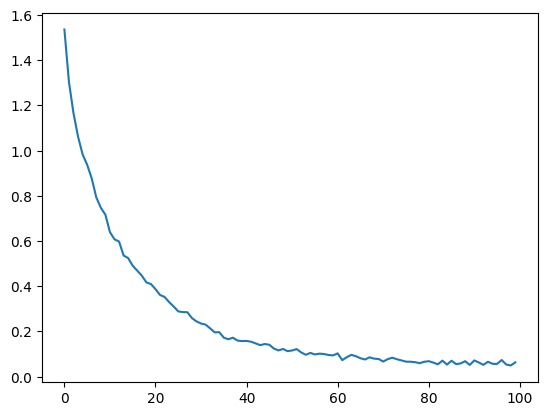

In [381]:
loss = metrics['loss']
epochs = np.arange(len(loss))

import matplotlib.pyplot as plt

plt.plot(epochs, loss)
plt.show()

In [397]:
inputs_batch, _, traj_batch = sample_batch(jax.random.PRNGKey(0), return_traj=True)
obs_pred = obs_model.apply(train_state.train_state.params, *inputs_batch)
pred_action_dist, _ = pretrained_policy(obs_pred)
pred_action_dist.probs[0]

Array([[5.2798246e-03, 9.4244671e-01, 8.4038853e-04, 2.5365487e-02,
        2.6067631e-02],
       [2.3741557e-03, 3.3842135e-04, 9.5885146e-01, 2.5261546e-02,
        1.3174479e-02],
       [2.6251113e-03, 4.3462240e-04, 9.5582706e-01, 2.1032613e-02,
        2.0080568e-02],
       [5.4556681e-03, 9.3995112e-01, 9.1198145e-04, 2.8415591e-02,
        2.5265722e-02]], dtype=float32)

In [395]:
obs_pred[0, 0], pred_action_dist.probs[0, 0].argmax(), actions_1h[0].argmax()

(Array([0.45964745, 0.5141256 , 0.4000706 , 0.45956847, 0.44683287,
        0.40524513, 0.37782028, 0.44487777, 0.52730125, 0.5978453 ,
        0.4977588 , 0.5413033 , 0.48969176, 0.47366473, 0.49637774,
        0.62922597, 0.566228  , 0.4735087 , 0.4013999 , 0.39769176],      dtype=float32),
 Array(1, dtype=int32),
 Array(1, dtype=int32))

In [398]:
traj_batch.obs[0, 0]

Array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0.], dtype=float32)

In [80]:
from poclaps.simple_gridworld_game import stringify_grid


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p.tolist()): 'X', tuple(g.tolist()): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))



def print_episode_with_info(goals, agent_pos, actions, rewards):
    grid_strings = []

    for g, p, a, r in zip(goals, agent_pos, actions, rewards):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p.tolist()): 'X', tuple(g.tolist()): 'G'
        })
        line_0, *_ = grid_str.split('\n')
        info_str = f'Act: {a} | Reward: {r}'
        info_str += ' ' * (len(line_0) - len(info_str))
        grid_strings.append(f'{info_str}\n{grid_str}')

    print(format_side_by_side(grid_strings))


def print_episode_in_batch(ep_id: int,
                           traj_batch: Transition,
                           info: bool = False):

    env_state = traj_batch.env_state.env_state
    ep_ids = traj_batch.episode_id
    goals = env_state.goal_pos[ep_ids == ep_id]
    agent_pos = env_state.agent_pos[ep_ids == ep_id]
    actions = traj_batch.action[ep_ids == ep_id]
    rewards = traj_batch.reward[ep_ids == ep_id]

    if info:
        print_episode_with_info(goals, agent_pos, actions, rewards)
    else:
        print_episode(goals, agent_pos)

In [81]:
ep_id = 1
print_episode_in_batch(ep_id, traj_batch)

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   | X |   |   |	|   | X |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   | X |   |   |   |	| X |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| G |   |   |   |   |	| G |   |   |   |   |	| G |   |   |   |   |	| G |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [133]:

forward_rrn = ScannedRNN()

N_ACTIONS = 5
actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
msgs_1h = jax.nn.one_hot(msgs_batch, comm_policy.n_msgs)
feats = jnp.concatenate([actions_1h, msgs_1h], axis=-1)

forward_carry = forward_rrn.initialize_carry(feats.shape)

model_inputs = (feats, traj_batch.done)

variables = forward_rrn.init(jax.random.PRNGKey(0), forward_carry, model_inputs)

_, forward_embs = forward_rrn.apply(variables, forward_carry, model_inputs)

In [104]:
obs.shape

(500, 4, 20)

In [122]:
obs.shape

(500, 4, 20)